# Introduction to TensorFlow
# Notebook - Automatic Differentiation

*Disclosure: This notebook is an adaptation of Toronto's Neural Networks and Deep Learning Course (CSC421) tutorial material.*

## Setup of python packages
Google Colaboratory comes with a preinstalled Python runtime    

In [2]:
# Show used python version
import sys
print(f"Used python version: {sys.version}")

Used python version: 3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]


Install any python package via pip within the virtual machine provided by colab using
    
    !pip install <package>

Note: each time the runtime is reset, you have to reinstall all required packages.
    

In [3]:
# Install symbolic python package
!pip install sympy

In [0]:
# Import the installed package
import sympy as sp

## Approaches for computing derivatives

* **Numeric differentiation:** Approximating derivatives by finite differences:
$$
\frac{\partial}{\partial x_i} f(x_1, \dots, x_N) = \lim_{h \to 0} \frac{f(x_1, \dots, x_i + h, \dots, x_N) - f(x_1, \dots, x_i - h, \dots, x_N)}{2h}
$$

* **Symbolic differentiation:** automatic manipulation of mathematical expressions to get derivatives
    - Takes a math expression (e.g. sigmoid) and returns a math expression: $$\sigma(x) = \frac{1}{e^{-x} + 1} \rightarrow \frac{d\sigma(x)}{dx} = \frac{e^{-x}}{(e^{-x} + 1)^2} = \sigma(x)(1 - \sigma(x)$$
    - Used in SymPy or Mathematica



In [5]:
# Use SymPy for symbolic differentiation
# E.g. sigmoid of convolution of two inputs
x_1, x_2, w_1, w_2, b_1 = sp.symbols('x_1, x_2, w_1, w_2, b_1', real=True)
g = 1 / (1 + sp.exp(-(w_1 * x_1 + w_2 * x_2 + b_1)))

print(f'Mathematical Expression: $$g(x) = {sp.latex(g)}$$')
print(f'Partial Derivatives:')
for var in [x_1, x_2]:
    print(f'$$ \\frac{{\\partial g}}{{\\partial {str(var)} }} = {sp.latex(sp.simplify(g.diff(var)))} $$')

Mathematical Expression: $$g(x) = \frac{1}{e^{- b_{1} - w_{1} x_{1} - w_{2} x_{2}} + 1}$$
Partial Derivatives:
$$ \frac{\partial g}{\partial x_1 } = \frac{w_{1} e^{- b_{1} - w_{1} x_{1} - w_{2} x_{2}}}{\left(e^{- b_{1} - w_{1} x_{1} - w_{2} x_{2}} + 1\right)^{2}} $$
$$ \frac{\partial g}{\partial x_2 } = \frac{w_{2} e^{- b_{1} - w_{1} x_{1} - w_{2} x_{2}}}{\left(e^{- b_{1} - w_{1} x_{1} - w_{2} x_{2}} + 1\right)^{2}} $$


If posted to a text cell, the code snippet generates the following latex expressions.

Mathematical Expression: $$g(x) = \frac{1}{e^{- b_{1} - w_{1} x_{1} - w_{2} x_{2}} + 1}$$
Partial Derivatives:
$$ \frac{\partial g}{\partial x_1 } = \frac{w_{1} e^{- b_{1} - w_{1} x_{1} - w_{2} x_{2}}}{\left(e^{- b_{1} - w_{1} x_{1} - w_{2} x_{2}} + 1\right)^{2}} $$
$$ \frac{\partial g}{\partial x_2 } = \frac{w_{2} e^{- b_{1} - w_{1} x_{1} - w_{2} x_{2}}}{\left(e^{- b_{1} - w_{1} x_{1} - w_{2} x_{2}} + 1\right)^{2}} $$

* **Automatic differentiation:** Takes code that computes a function and returns code that computes the derivative of that function.
    - Reverse Mode AD: A method to get exact derivatives efficiently, by storing information as you go forward that you can reuse as you go backwards
    - The goal isn't to obtain closed-form solutions, but to be able to wirte a program that efficiently computes the derivatives (Backpropagation)

## Autograd

* [Autograd](https://github.com/HIPS/autograd) is a Python package for automatic differentiation.
* There are a lot of great [examples](https://github.com/HIPS/autograd/tree/master/examples) provided with the source code

### What can Autograd do?

From the Autograd Github repository:

* Autograd can automatically differentiate native Python and Numpy code.
* It can handle a large subset of Python's features, including loops, conditional statements (if/else), recursion and closures
* It can also compute higher-order derivatives
* It uses reverse-mode differentiation (a.k.a. backpropagation) so it can efficiently take gradients of scalar-valued functions with respect to array-valued arguments.

### Autograd vs Deep Learning Frameworks

Many Deep Learning packages implement automatic differentiation using _domain-specific languages_ within Python. Older versions, such as TensorFlow 1.X, required you to _explicitly_ construct a computation graph; Autograd constructs a computation graph _implicitly_, by tracking the sequence of operations that have been performed during the execution of a program.

Note: There is no direct GPU support for Autograd. If you're interested in automatic differentiation with support for hardware accelerators have a look at [JAX](https://github.com/google/jax). It is a successor that provides Just-in-Time compilation like PyTorch or TensorFlow. 

## Autograd Basic Usage

Autograd wraps the NumPy package providing an almost identical API to the NumPy functionality, but performs additional bookkeeping in the background to build the computation graph.

In [6]:
# Install autograd
!pip install autograd

In [0]:
# Import autograd
import autograd.numpy as np # Import thinly-wrapped NumPy
from autograd import grad   # The only function of Autograd, you need to call

In [8]:
# Define a function like normal, using Python and Numpy
def tanh(x):
    y = np.exp(-x)
    return (1.0 - y) / (1.0 + y)

# Create a *function* that computes the gradient of tanh
grad_tanh = grad(tanh)  # autograd.grad takes a function as input

# Evaluate the gradient at x = 1.0
print(f'Autograd gradient:  {grad_tanh(1.0)}')

# Compare to numeric gradient computed using finite differences
h = 0.0001
print(f'Finite differences: {(tanh(1.0001) - tanh(0.9999)) / (2*h)}')

Autograd gradient:  0.39322386648296376
Finite differences: 0.39322386636453377


## Autograd vs Manual Gradients via Staged Computation

In this example, we will see how the computation of a function can be written as a composition of simpler functions. This provides a scalable strategy for computing gradients using the chain rule.

Say we want to write a function to compute the gradient of the *sigmoid function*:
$$
\sigma(x) = \frac{1}{e^{-x} + 1}
$$
We can write $\sigma(x)$ as a composition of several elementary functions, as $\sigma(x) = s(c(b(a(x))))$, where:

$$
a(x) = -x
$$

$$
b(a) = e^a
$$

$$
c(b) = 1 + b
$$

$$
s(c) = \frac{1}{c}
$$

Here, we have "staged" the computation such that it contains several intermediate variables, each of which are basic expressions for which we can easily compute the local gradients.

The input to this function is $x$, and the final output is represented by $s$. We wish compute the gradient of $d$ with respect to $x$, $\frac{\partial s}{\partial x}$. In order to make use of our intermediate computations, we can use the chain rule as follows:
$$
\frac{\partial s}{\partial x} = \frac{\partial s}{\partial c} \frac{\partial c}{\partial b} \frac{\partial b}{\partial a} \frac{\partial a}{\partial x}
$$

In [9]:
def grad_sigmoid_manual(x):
    """Implements the gradient of the logistic sigmoid function 
    $\sigma(x) = 1 / (1 + e^{-x})$ using staged computation
    """
    # Forward pass, keeping track of intermediate values for use in the 
    # backward pass
    a = -x         # -x in denominator
    b = np.exp(a)  # e^{-x} in denominator
    c = 1 + b      # 1 + e^{-x} in denominator
    s = 1.0 / c    # Final result, 1.0 / (1 + e^{-x})
    
    # Backward pass
    dsdc = (-1.0 / (c**2))
    dsdb = dsdc * 1
    dsda = dsdb * np.exp(a)
    dsdx = dsda * (-1)
    
    return dsdx

def sigmoid(x):
    y = 1.0 / (1.0 + np.exp(-x))
    return y

# Instead of writing grad_sigmoid_manual manually, we can use 
# Autograd's grad function:
grad_sigmoid_automatic = grad(sigmoid)

# Compare the results of manual and automatic gradient functions:
print(f'Autograd gradient:  {grad_sigmoid_automatic(2.0)}')
print(f'Manual gradient:    {grad_sigmoid_manual(2.0)}')

Autograd gradient:  0.1049935854035065
Manual gradient:    0.1049935854035065


# Example

## Linear Regression with Autograd


The next section of the notebook shows an example of using Autograd in the context of **1-D linear regression** by gradient descent.

We try to fit a model to a function $y = wx + b$

### Review

We are given a set of data points $\{ (x_1, t_1), (x_2, t_2), \dots, (x_N, t_N) \}$, where each point $(x_i, t_i)$ consists of an *input value* $x_i$ and a *target value* $t_i$. 

The **model** we use is:
$$
y_i = wx_i + b
$$

We want each predicted value $y_i$ to be close to the ground truth value $t_i$. In linear regression, we use squared error to quantify the disagreement between $y_i$ and $t_i$. The **loss function** for a single example is:
$$
\mathcal{L}(y_i,t_i) = \frac{1}{2} (y_i - t_i)^2
$$

The **cost function** is the loss averaged over all the training examples:
$$
\mathcal{C}(w,b) = \frac{1}{N} \sum_{i=1}^N \mathcal{L}(y_i, t_i) = \frac{1}{N} \sum_{i=1}^N \frac{1}{2} \left(wx_i + b - t_i \right)^2
$$

In [0]:
import autograd.numpy as np # Import wrapped NumPy from Autograd
from autograd import grad # To compute gradients

import matplotlib.pyplot as plt # Most common plotting / data visualization tool in Python

## Generate Synthetic Data

We generate a synthetic dataset $\{ (x_i, t_i) \}$ by first taking the $x_i$ to be linearly spaced in the range $[0, 1]$ and generating the corresponding value of $t_i$ using the following equation (where $w = 2$ and $b=0.5$):
$$
t_i = 2 x_i + 0.5 + \epsilon
$$

Here, $\epsilon \sim \mathcal{N}(0, 0.01)$ (that is, $\epsilon$ is drawn from a Gaussian distribution with mean 0 and variance 0.01). This introduces some random fluctuation in the data, to mimic real data that has an underlying regularity, but for which individual observations are corrupted by random noise.

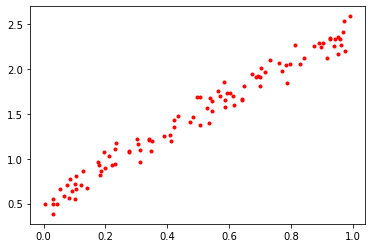

In [11]:
# In our synthetic data, we have w = 2 and b = 0.5
N = 100 # Number of training data points
x = np.random.uniform(size=(N,))
eps = np.random.normal(size=(len(x),), scale=0.1)
t = 2.0 * x + 0.5 + eps
plt.plot(x, t, 'r.')

In [13]:
# Initialize random parameters
w = np.random.normal(0, 1)
b = np.random.normal(0, 1)
params = { 'w': w, 'b': b } # One option: aggregate parameters in a dictionary

def cost(params):
    y = params['w'] * x + params['b']
    return (1 / N) * np.sum(0.5 * np.square(y - t))

# Find the gradient of the cost function using Autograd
grad_cost = grad(cost) 

num_epochs = 2000  # Number of epochs of training
alpha = 0.025       # Learning rate

for i in range(num_epochs):
    # Evaluate the gradient of the current parameters stored in params
    cost_params = grad_cost(params)
    
    # Gradient Descent step
    # Update parameters w and b
    params['w'] = params['w'] - alpha * cost_params['w']
    params['b'] = params['b'] - alpha * cost_params['b']

print(params)

{'w': 1.926380013972517, 'b': 0.5288309549899681}


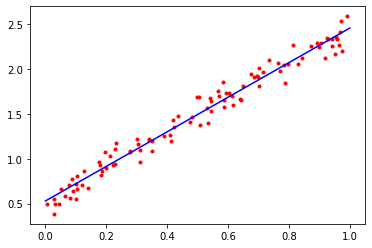

In [14]:
# Plot the training data again, together with the line defined by y = wx + b
# where w and b are our final learned parameters
plt.plot(x, t, 'r.')
plt.plot([0, 1], [params['b'], params['w'] + params['b']], 'b-')